In [ ]:
print("hello")

hello


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import os

In [9]:
carData_filepath = "/content/coches_data_compiled_2025-02-27_11-31.parquet"

# Load dataset
df = pd.read_parquet(carData_filepath)
print(df.columns)
print(df.describe())



Index(['Title', 'Price', 'Features', 'URL', 'Scrape Date', 'ListingInfo',
       'Source File'],
      dtype='object')
                               Title     Price Features  \
count                          26698     26698    26698   
unique                          9544      2836    24873   
top     TOYOTA C-HR 1.8 125H Advance  19.990 €            
freq                             127       280       15   

                                                      URL Scrape Date  \
count                                               26698       26698   
unique                                              25278           1   
top     https://www.coches.net/mitsubishi-montero-dies...  2025-02-27   
freq                                                    4       26698   

                                          ListingInfo  \
count                                           26698   
unique                                          21667   
top     Publicado: Ayer 15:20, modificado: Ayer 

Combined dataframe. This should be done with lists for faster performance, not the dataframes themselves.

In [10]:


df = df.drop('Scrape Date', axis=1)
df = df.drop_duplicates()

In [11]:
df.describe()
#print(df["Features"])

,Title,Price,Features,URL,ListingInfo,Source File
count,26320,26320,26320,26320,26320,26320
unique,9544,2836,24873,25278,21667,9
top,TOYOTA C-HR 1.8 125H Advance,19.990 €,,https://www.coches.net/toyota-rav4-2.0d-150d-2...,"Publicado: Ayer 15:20, modificado: Ayer 15:20",car_links_2025-02-27_01-29.txt
freq,124,276,15,2,138,2977


In [12]:
# Split features into separate columns
df["FeaturesList"] = df["Features"].str.split(", ")
features_df = df["FeaturesList"].apply(pd.Series)

#concatenate back the desired features
df = pd.concat([df, features_df.iloc[:, [0, 1]]], axis=1)
df = df.rename(columns={1: "KM", 0: "YEAR"})


In [13]:
# Split features into separate columns
df["BrandModel"] = df["Title"].str.split(" ")
features_df = df["BrandModel"].apply(pd.Series)

#concatenate back the desired features
df = pd.concat([df, features_df.iloc[:, [0, 1]]], axis=1)
df = df.rename(columns={1: "Model", 0: "Brand"})

print(df.columns)


Index(['Title', 'Price', 'Features', 'URL', 'ListingInfo', 'Source File',
       'FeaturesList', 'YEAR', 'KM', 'BrandModel', 'Brand', 'Model'],
      dtype='object')


In [14]:
# Clean and convert YEAR column
df["YEAR"] = (
    df["YEAR"]
    .astype(str)  # Ensure it's a string
    .str.strip()  # Remove leading/trailing spaces
    .replace("", np.nan)  # Convert empty strings to NaN
    .dropna()  # Remove NaN values
    .astype(int)  # Convert to integer
)

# Convert price to integer (removing non-digit characters)
df["PriceInt"] = (
    df["Price"].astype(str)
    .str.replace(r"[^\d]", "", regex=True)  # Keep only digits
    .replace("", np.nan)  # Replace empty strings with NaN
    .dropna()  # Drop NaN rows
    .astype(float)  # Convert to float
)

# Clean and convert KM column
df["KM"] = df["KM"].str.replace(r"[^\d]", "", regex=True).astype(float) # Convert to float
df = df.dropna()

df = df.sort_values("KM")
print(df.columns)


Index(['Title', 'Price', 'Features', 'URL', 'ListingInfo', 'Source File',
       'FeaturesList', 'YEAR', 'KM', 'BrandModel', 'Brand', 'Model',
       'PriceInt'],
      dtype='object')


In [15]:
df["Brand"].value_counts()

,count
Brand,
MERCEDES-BENZ,2376
VOLKSWAGEN,2103
BMW,2047
PEUGEOT,1906
AUDI,1536
...,...
PIAGGIO,1
MAXUS,1
ZHIDOU,1


In [16]:
df = df.query("PriceInt <= 50000")
#df = df[df["Brand"] == "CUPRA"]
df = df.query("YEAR > 2005")
df = df.query("KM < 200000")
#df = df.query("PriceInt < 500000")



In [17]:
# Define independent variables and target variable
X = df[["KM", "YEAR"]]
y = df["PriceInt"]

# Train the regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [18]:
df['Predicted_Price'] = model.predict(X)

In [19]:
df['Predicted_Price'] = model.predict(X)

# Create a grid for the regression plane
km_range = np.linspace(df["KM"].min(), df["KM"].max(), 20)
year_range = np.linspace(df["YEAR"].min(), df["YEAR"].max(), 20)
KM_grid, Year_grid = np.meshgrid(km_range, year_range)

# Compute predicted prices for the grid using the linear regression model
Z = model.intercept_ + model.coef_[0] * KM_grid + model.coef_[1] * Year_grid

print(Z.shape)


(20, 20)


KeyboardInterrupt: 

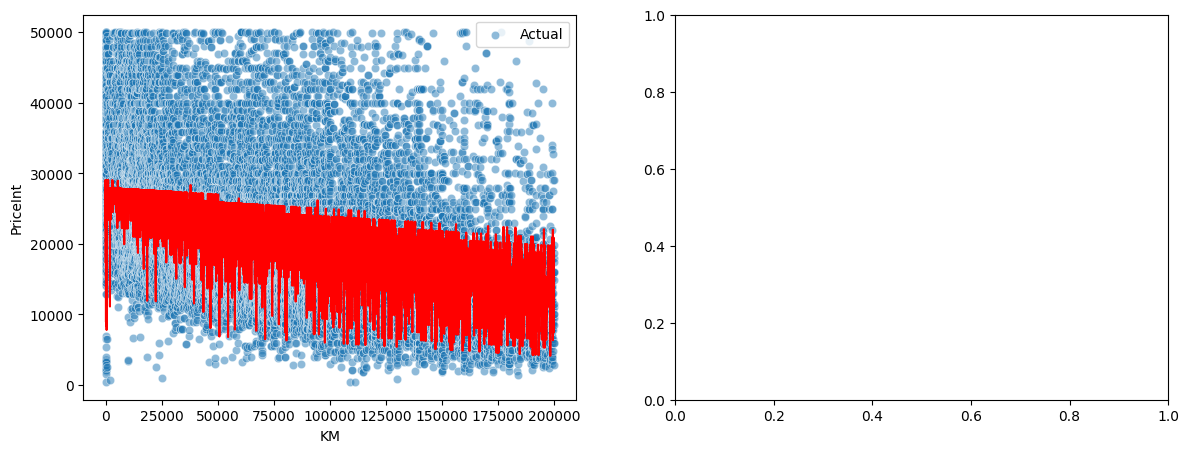

In [20]:
# Create scatter plots with regression lines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=df['KM'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[0])
sns.lineplot(x=df['KM'], y=df['Predicted_Price'], color='red', label='Predicted', ax=axes[0])
axes[0].set_title('Price vs. KM')
axes[0].set_xlabel('KM (KM)')
axes[0].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['YEAR'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[1])
sns.lineplot(x=df['YEAR'], y=df['Predicted_Price'], color='red', label='Predicted', ax=axes[1])
axes[1].set_title('Price vs. Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Price (PriceInt)')

plt.tight_layout()
plt.show()  # ✅ Ensures the first plot is displayed before moving to the next


In [ ]:
# Create a grid for the regression plane
km_range = np.linspace(df["KM"].min(), df["KM"].max(), 20)
year_range = np.linspace(df["YEAR"].min(), df["YEAR"].max(), 20)
KM_grid, Year_grid = np.meshgrid(km_range, year_range)

# Compute predicted prices for the grid using the linear regression model
Z = model.intercept_ + model.coef_[0] * KM_grid + model.coef_[1] * Year_grid

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of actual data points
ax.scatter(df["KM"], df["YEAR"], df["PriceInt"], c='blue', marker='o', alpha=0.5, label="Actual Prices")
ax.scatter(df["KM"], df["YEAR"], df["Predicted_Price"], c='black', marker='*', alpha=0.9, label="Predicted prices")


# Plot the regression plane
ax.plot_surface(KM_grid, Year_grid, Z, color='red', alpha=0.3, edgecolor='k')

# Labels and title
ax.set_xlabel('KM')
ax.set_ylabel('Year')
ax.set_zlabel('Price (PriceInt)')
ax.set_title('3D Regression Plane: Price vs KM & Year')

# Show the plot
plt.legend()
plt.show()


NameError: name 'model' is not defined

In [ ]:
# Define independent variables and target variable
df['YEAR2'] = df[["YEAR"]] * df[['YEAR']]
X = df[["YEAR2", "YEAR", "KM"]]
y = df["PriceInt"]

# Train the regression model
modelSquared = LinearRegression()
modelSquared.fit(X, y)

print(modelSquared.coef_)

[ 3.18702012e+02 -1.28914722e+06 -1.29107555e-01]


KeyError: 'Predicted_Price'

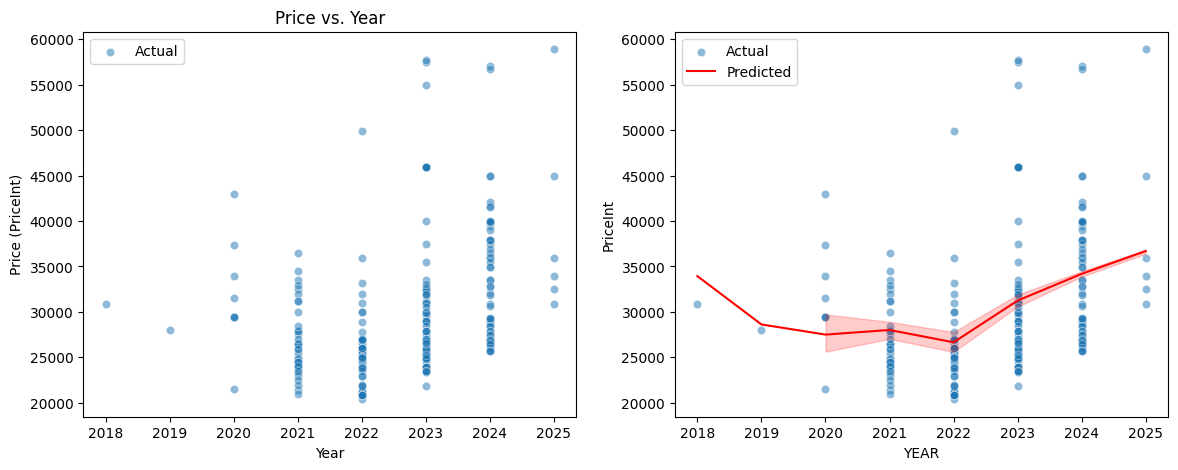

In [ ]:
df['Predicted_Price_squared'] = modelSquared.predict(X)

# Create scatter plots with regression lines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


sns.scatterplot(x=df['YEAR'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[1])
sns.lineplot(x=df['YEAR'], y=df['Predicted_Price_squared'], color='red', label='Predicted', ax=axes[1])
axes[0].set_title('Price vs. Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['YEAR'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[0])
sns.lineplot(x=df['YEAR'], y=df['Predicted_Price'], color='red', label='Predicted', ax=axes[0])
axes[1].set_title('Price vs. Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Price (PriceInt)')

plt.tight_layout()
plt.show()  # ✅ Ensures the first plot is displayed before moving to the next


[ -489.90760837 -1183.12316483]


C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_9372\1671337686.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


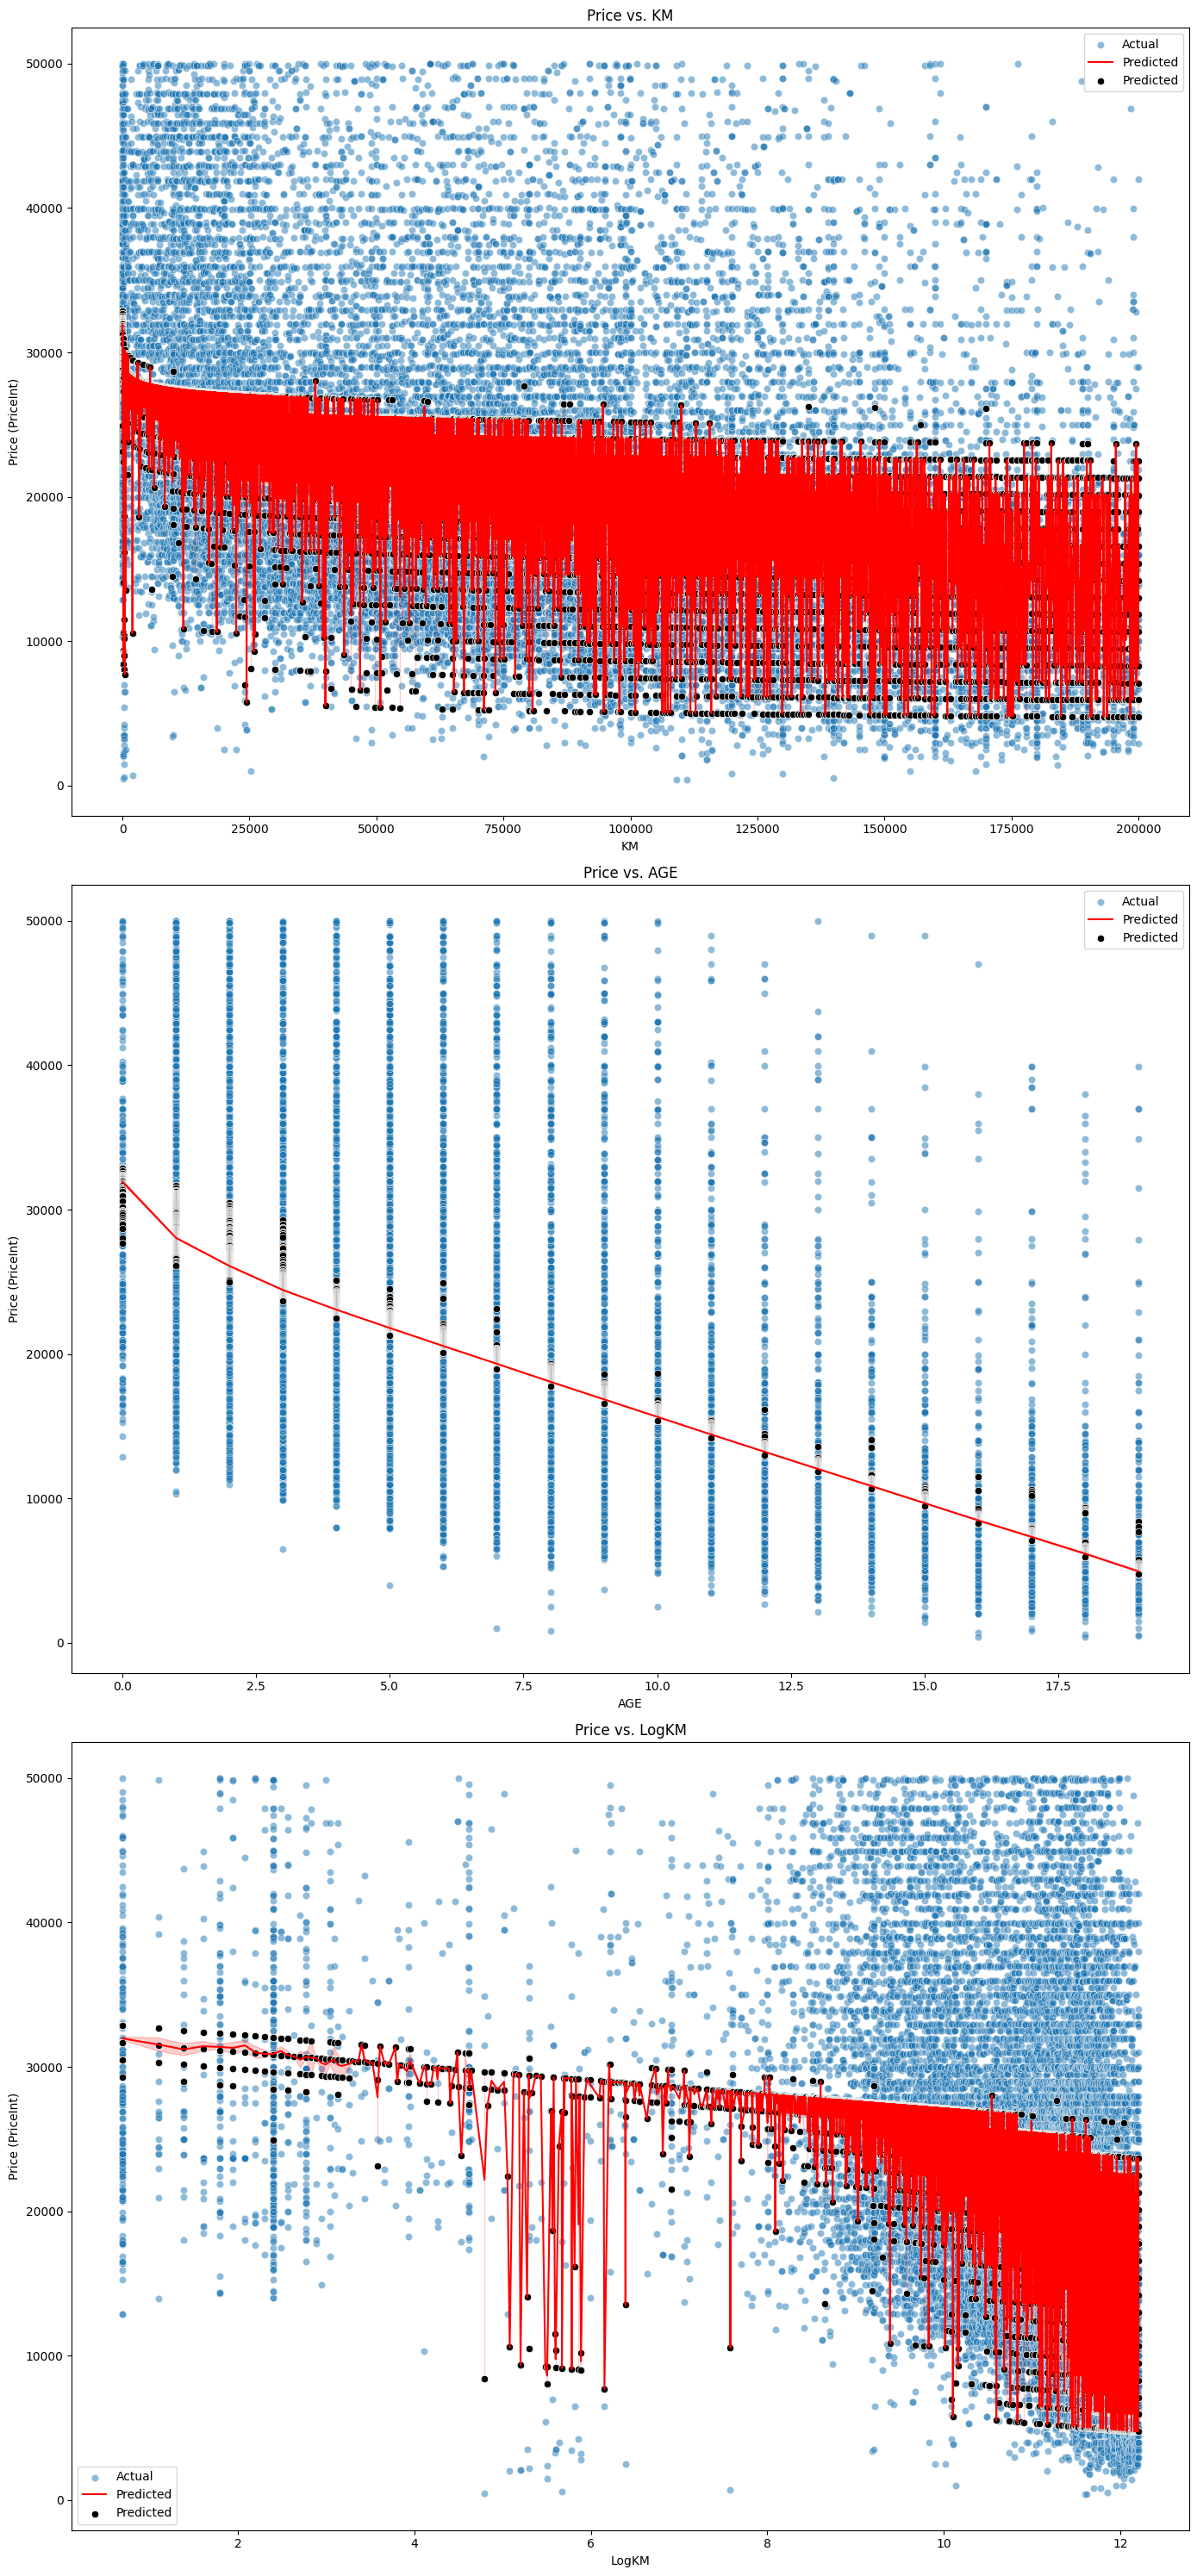

In [ ]:
# Define independent variables and target variable
df['LogKM'] = np.log1p(df['KM'])  # Apply log transformation to KM
df['AGE'] = 2025 - df['YEAR']  # Assuming current year is 2025


X = df[["LogKM", "AGE"]]
y = df["PriceInt"]

# Train the regression model
modelLog = LinearRegression()
modelLog.fit(X, y)

print(modelLog.coef_)

df['Predicted_Price_log'] = modelLog.predict(X)

# Create scatter plots with regression lines
fig, axes = plt.subplots(3, 1, figsize=(14, 30))

sns.scatterplot(x=df['AGE'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[1])
sns.lineplot(x=df['AGE'], y=df['Predicted_Price_log'], color='red', label='Predicted', ax=axes[1])
sns.scatterplot(x=df['AGE'], y=df['Predicted_Price_log'], color='black', label='Predicted', ax=axes[1])
axes[1].set_title('Price vs. AGE')
axes[1].set_xlabel('AGE')
axes[1].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['KM'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[0])
sns.lineplot(x=df['KM'], y=df['Predicted_Price_log'], color='red', label='Predicted', ax=axes[0], sort=False)
sns.scatterplot(x=df['KM'], y=df['Predicted_Price_log'], color='black', label='Predicted', ax=axes[0])
axes[0].set_title('Price vs. KM')
axes[0].set_xlabel('KM')
axes[0].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['LogKM'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[2])
sns.lineplot(x=df['LogKM'], y=df['Predicted_Price_log'], color='red', label='Predicted', ax=axes[2], sort=False)
sns.scatterplot(x=df['LogKM'], y=df['Predicted_Price_log'], color='black', label='Predicted', ax=axes[2])
axes[2].set_title('Price vs. LogKM')
axes[2].set_xlabel('LogKM')
axes[2].set_ylabel('Price (PriceInt)')

plt.tight_layout()
plt.show()


In [ ]:
np.transpose([df.groupby("AGE")["PriceInt"].mean(),
df.groupby("AGE")["PriceInt"].mean().diff()])

array([[29639.75577558,            nan],
       [29240.94390832,  -398.81186725],
       [26851.41702128, -2389.52688705],
       [22958.94254875, -3892.47447253],
       [22336.36376365,  -622.57878509],
       [22709.27263401,   372.90887036],
       [20098.11466058, -2611.15797343],
       [19130.46386758,  -967.650793  ],
       [18002.35326087, -1128.11060671],
       [16657.94692949, -1344.40633138],
       [14918.63393708, -1739.31299241],
       [13968.43211488,  -950.2018222 ],
       [12655.16330645, -1313.26880843],
       [12078.40961098,  -576.75369547],
       [11143.01612903,  -935.39348195],
       [ 9758.72606383, -1384.2900652 ],
       [ 8424.29283489, -1334.43322894],
       [ 8934.95483871,   510.66200382],
       [ 7507.45454545, -1427.50029326],
       [ 7192.36904762,  -315.08549784]])

[-1224.4538694]


C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_6336\2775585903.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\PORTATIL\OneDrive\Documentos\Projects\CochecitosScrapping\venvCars\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


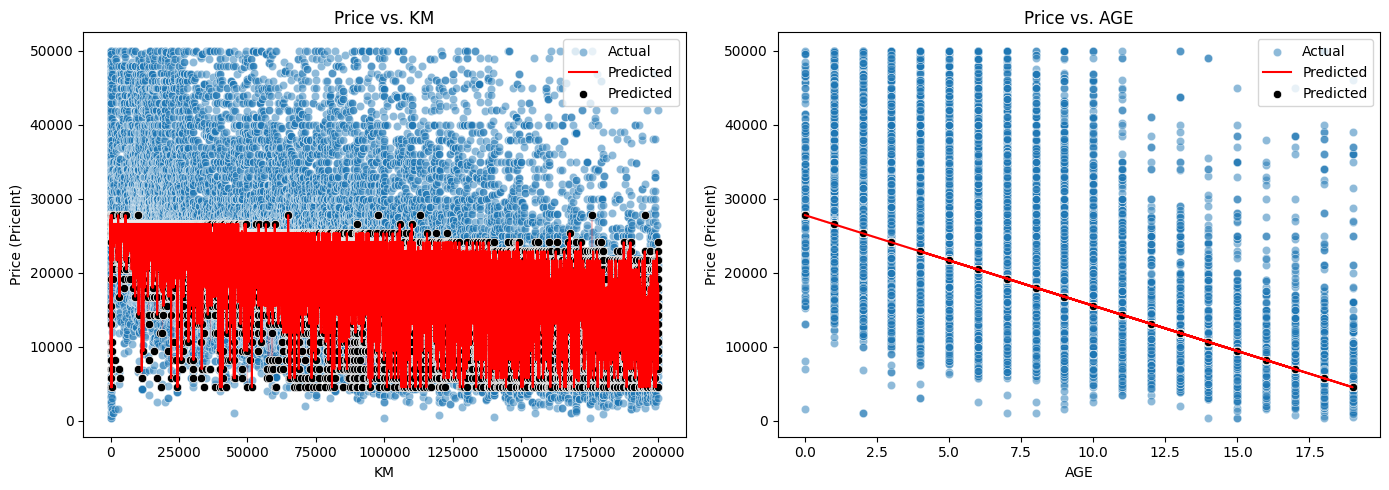

In [ ]:
# Define independent variables and target variable
#df['LogKM'] = np.log1p(df['KM'])  # Apply log transformation to KM
#df['AGE'] = 2025 - df['YEAR']  # Assuming current year is 2025


X = df[["AGE"]]
y = df["PriceInt"]

# Train the regression model
modelAge = LinearRegression()
modelAge.fit(X, y)

print(modelAge.coef_)

df['Predicted_Price_age'] = modelAge.predict(X)

# Create scatter plots with regression lines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=df['AGE'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[1])
sns.lineplot(x=df['AGE'], y=df['Predicted_Price_age'], color='red', label='Predicted', ax=axes[1], sort=False)
sns.scatterplot(x=df['AGE'], y=df['Predicted_Price_age'], color='black', label='Predicted', ax=axes[1])

axes[1].set_title('Price vs. AGE')
axes[1].set_xlabel('AGE')
axes[1].set_ylabel('Price (PriceInt)')


sns.scatterplot(x=df['KM'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[0])
sns.lineplot(x=df['KM'], y=df['Predicted_Price_age'], color='red', label='Predicted', ax=axes[0])
sns.scatterplot(x=df['KM'], y=df['Predicted_Price_age'], color='black', label='Predicted', ax=axes[0])

axes[0].set_title('Price vs. KM')
axes[0].set_xlabel('KM')
axes[0].set_ylabel('Price (PriceInt)')

plt.tight_layout()
plt.show()

In [21]:

# Group data by model and get the oldest and newest prices
oldest_newest_prices_1 = df.groupby('Model')['PriceInt'].agg(['min', 'max'])

# Calculate depreciation
oldest_newest_prices_1['Depreciation'] = 100 * (oldest_newest_prices_1['min'] - oldest_newest_prices_1['max']) / oldest_newest_prices_1['min']

# Merge depreciation back into the original DataFrame
df = pd.merge(df, oldest_newest_prices_1['Depreciation'], left_on='Model', right_index=True)


In [27]:
# Ordenar el DataFrame por depreciación de menor a mayor
df_sorted = df.sort_values(by='Depreciation', ascending=True)

# Mostrar el DataFrame ordenado
df_sorted

,Title,Price,Features,URL,ListingInfo,Source File,FeaturesList,YEAR,KM,BrandModel,Brand,Model,PriceInt,Predicted_Price,Depreciation
1302,CITROEN Berlingo Talla M PureTech 110 SS FEEL,18.990 €,"2021, 53.000 km, Vizcaya, Monovolumen, Cambio ...",https://www.coches.net/citroen-berlingo-talla-...,"Publicado: 11/02 15:21, modificado: Ayer 15:15",car_links_2025-02-26_20-45.txt,"[2021, 53.000 km, Vizcaya, Monovolumen, Cambio...",2021.0,53000.0,"[CITROEN, Berlingo, Talla, M, PureTech, 110, S...",CITROEN,Berlingo,18990.0,23601.857328,-7625.0
10631,CITROEN Berlingo 1.6 HDi 90 Attraction,9.990 €,"2014, 178.000 km, Sta. C. Tenerife, Monovolume...",https://www.coches.net/citroen-berlingo-1.6-hd...,"Publicado: 20/02 21:42, modificado: Ayer 09:38",car_links_2025-02-26_23-35.txt,"[2014, 178.000 km, Sta. C. Tenerife, Monovolum...",2014.0,178000.0,"[CITROEN, Berlingo, 1.6, HDi, 90, Attraction]",CITROEN,Berlingo,9990.0,13461.189992,-7625.0
15878,CITROEN Berlingo,6.050 €,"2015, 146.000 km, Toledo, Cambio Manual, 5 Pue...",https://www.coches.net/citroen-berlingo-diesel...,"Publicado: Ayer 08:50, modificado: Ayer 08:50",car_links_2025-02-27_01-29.txt,"[2015, 146.000 km, Toledo, Cambio Manual, 5 Pu...",2015.0,146000.0,"[CITROEN, Berlingo]",CITROEN,Berlingo,6050.0,15171.768063,-7625.0
10889,CITROEN Berlingo Talla M BlueHDi 100 SS SHINE,18.985 €,"2021, 41.184 km, Sta. C. Tenerife, Monovolumen...",https://www.coches.net/citroen-berlingo-talla-...,"Publicado: 06/02 16:26, modificado: Ayer 11:38",car_links_2025-02-26_23-35.txt,"[2021, 41.184 km, Sta. C. Tenerife, Monovolume...",2021.0,41184.0,"[CITROEN, Berlingo, Talla, M, BlueHDi, 100, SS...",CITROEN,Berlingo,18985.0,23820.677613,-7625.0
13260,CITROEN Berlingo Talla XL BlueHDi 130 SS 6v FEEL,18.900 €,"2020, 116.000 km, Pontevedra, Monovolumen, Cam...",https://www.coches.net/citroen-berlingo-talla-...,"Publicado: 01/10 11:01, modificado: Ayer 08:21",car_links_2025-02-27_00-33.txt,"[2020, 116.000 km, Pontevedra, Monovolumen, Ca...",2020.0,116000.0,"[CITROEN, Berlingo, Talla, XL, BlueHDi, 130, S...",CITROEN,Berlingo,18900.0,21317.190831,-7625.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16298,BMW 518D TOURING M-SPORT AUTO,24.950 €,"2020, 84.547 km, Madrid, Familiar, Cambio Auto...",https://www.coches.net/bmw-518d-touring-m-spor...,"Publicado: 17/10 08:29, modificado: Ayer 16:57",car_links_2025-02-27_01-29.txt,"[2020, 84.547 km, Madrid, Familiar, Cambio Aut...",2020.0,84547.0,"[BMW, 518D, TOURING, M-SPORT, AUTO]",BMW,518D,24950.0,21899.668355,0.0
19429,AUDI RS7 Sportback 4.0 TFSI 560 quattro tiptronic,48.000 €,"2014, 120.000 km, Madrid, Berlina, Cambio Auto...",https://www.coches.net/audi-rs7-sportback-4.0-...,"Publicado: 22/02 19:52, modificado: Ayer 12:28",car_links_2025-02-27_02-27.txt,"[2014, 120.000 km, Madrid, Berlina, Cambio Aut...",2014.0,120000.0,"[AUDI, RS7, Sportback, 4.0, TFSI, 560, quattro...",AUDI,RS7,48000.0,14535.290917,0.0
15572,MAZDA MX30 eSKYACTIVE Advantage Modern Conf.,26.900 €,"2023, 9.000 km, Pontevedra, SUV, Cambio Automá...",https://www.coches.net/mazda-mx-30-eskyactive-...,"Publicado: 03/08 17:37, modificado: Ayer 17:04",car_links_2025-02-27_01-29.txt,"[2023, 9.000 km, Pontevedra, SUV, Cambio Autom...",2023.0,9000.0,"[MAZDA, MX30, eSKYACTIVE, Advantage, Modern, C...",MAZDA,MX30,26900.0,26652.633841,0.0
21174,PORSCHE Cayman 2.7,26.990 €,"2007, 145.494 km, Tarragona, Coupe, Cambio Man...",https://www.coches.net/porsche-cayman-2.7-3p-g...,"Publicado: 24/12 09:24, modificado: Ayer 10:51",car_links_2025-02-27_03-25.txt,"[2007, 145.494 km, Tarragona, Coupe, Cambio Ma...",2007.0,145494.0,"[PORSCHE, Cayman, 2.7]",PORSCHE,Cayman,26990.0,6237.373350,0.0


In [32]:
# Obtener el precio del año más antiguo y más reciente por modelo
oldest_newest_prices_2 = df.loc[df.groupby('Model')['YEAR'].idxmin(), ['Model', 'PriceInt']].rename(columns={'PriceInt': 'oldest_price'})
newest_prices = df.loc[df.groupby('Model')['YEAR'].idxmax(), ['Model', 'PriceInt']].rename(columns={'PriceInt': 'newest_price'})

# Unir ambos precios en un solo DataFrame
oldest_newest_prices_2 = pd.merge(oldest_newest_prices_2, newest_prices, on='Model')

# Calcular la depreciación desde el año más reciente al más antiguo
oldest_newest_prices_2['Depreciation_2'] = 100 * (oldest_newest_prices_2['oldest_price'] - oldest_newest_prices_2['newest_price']) / oldest_newest_prices_2['oldest_price']

# Unir la depreciación al DataFrame original
df = pd.merge(df, oldest_newest_prices_2[['Model', 'Depreciation_2']], on='Model')


In [40]:
# Ordenar el DataFrame por depreciación de menor a mayor
df_sorted = df.sort_values(by='Depreciation_y', ascending=True)

# Mostrar el DataFrame ordenado
df_sorted

,Title,Price,Features,URL,ListingInfo,Source File,FeaturesList,YEAR,KM,BrandModel,Brand,Model,PriceInt,Predicted_Price,Depreciation_x,Depreciation_y,Depreciation_2
14435,CITROEN Berlingo Talla M BlueHDi 100 SS FEEL,13.990 €,"2020, 92.145 km, Jaén, Monovolumen, Cambio Man...",https://www.coches.net/citroen-berlingo-talla-...,"Publicado: 25/02 20:45, modificado: 25/02 20:45",car_links_2025-02-27_03-25.txt,"[2020, 92.145 km, Jaén, Monovolumen, Cambio Ma...",2020.0,92145.0,"[CITROEN, Berlingo, Talla, M, BlueHDi, 100, SS...",CITROEN,Berlingo,13990.0,21758.961134,-7625.000000,-6525.000000,-6525.000000
9998,CITROEN Berlingo Talla M BlueHDi 100 FEEL,18.890 €,"2019, 63.623 km, Málaga, Monovolumen, Cambio M...",https://www.coches.net/citroen-berlingo-talla-...,"Publicado: 31/01 11:44, modificado: 25/02 19:16",car_links_2025-02-27_03-25.txt,"[2019, 63.623 km, Málaga, Monovolumen, Cambio ...",2019.0,63623.0,"[CITROEN, Berlingo, Talla, M, BlueHDi, 100, FEEL]",CITROEN,Berlingo,18890.0,21169.188858,-7625.000000,-6525.000000,-6525.000000
19649,CITROEN Berlingo Multispace LIVE Edition BlueH...,10.990 €,"2016, 142.528 km, Córdoba, Monovolumen, Cambio...",https://www.coches.net/citroen-berlingo-multis...,"Publicado: 12/02 10:26, modificado: Ayer 16:30",car_links_2025-02-26_20-45.txt,"[2016, 142.528 km, Córdoba, Monovolumen, Cambi...",2016.0,142528.0,"[CITROEN, Berlingo, Multispace, LIVE, Edition,...",CITROEN,Berlingo,10990.0,16354.036632,-7625.000000,-6525.000000,-6525.000000
12266,CITROEN Berlingo Talla XL BlueHDi 100 SHINE,17.900 €,"2019, 77.500 km, Barcelona, Monovolumen, Cambi...",https://www.coches.net/citroen-berlingo-talla-...,"Publicado: 19/12 15:57, modificado: Ayer 19:06",car_links_2025-02-26_20-45.txt,"[2019, 77.500 km, Barcelona, Monovolumen, Camb...",2019.0,77500.0,"[CITROEN, Berlingo, Talla, XL, BlueHDi, 100, S...",CITROEN,Berlingo,17900.0,20912.200952,-7625.000000,-6525.000000,-6525.000000
11421,CITROEN Berlingo Talla M BlueHDi 130 SS 6v SHINE,21.599 €,"2020, 72.043 km, Madrid, Monovolumen, Cambio A...",https://www.coches.net/citroen-berlingo-talla-...,"Publicado: Ayer 15:20, modificado: Ayer 15:20",car_links_2025-02-26_20-45.txt,"[2020, 72.043 km, Madrid, Monovolumen, Cambio ...",2020.0,72043.0,"[CITROEN, Berlingo, Talla, M, BlueHDi, 130, SS...",CITROEN,Berlingo,21599.0,22131.229699,-7625.000000,-6525.000000,-6525.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,FIAT Fullback Doble Cabina Cross 2.4 Desel 4x4,14.500 €,"2019, 10 km, Sevilla, Pick Up, Cambio Manual, ...",https://www.coches.net/fiat-fullback-doble-cab...,"Publicado: 20/02 19:02, modificado: Ayer 10:19",car_links_2025-02-27_02-27.txt,"[2019, 10 km, Sevilla, Pick Up, Cambio Manual,...",2019.0,10.0,"[FIAT, Fullback, Doble, Cabina, Cross, 2.4, De...",FIAT,Fullback,14500.0,22347.236826,-65.517241,39.583333,39.583333
17784,FIAT Fullback Opening Ed.Dob.Cab.2.4D 4x4 Euro5,24.000 €,"2016, 120.989 km, Girona, Pick Up, Cambio Manu...",https://www.coches.net/fiat-fullback-opening-e...,"Publicado: Ayer 16:37, modificado: Ayer 16:37",car_links_2025-02-27_01-29.txt,"[2016, 120.989 km, Girona, Pick Up, Cambio Man...",2016.0,120989.0,"[FIAT, Fullback, Opening, Ed.Dob.Cab.2.4D, 4x4...",FIAT,Fullback,24000.0,16752.916973,-65.517241,39.583333,39.583333
16022,SUBARU Impreza 2.0R CLASSIC,10.300 €,"2010, 104.906 km, Murcia, Berlina, Cambio Manu...",https://www.coches.net/subaru-impreza-2.0r-cla...,"Publicado: 10/02 12:24, modificado: Ayer 17:43",car_links_2025-02-26_21-42.txt,"[2010, 104.906 km, Murcia, Berlina, Cambio Man...",2010.0,104906.0,"[SUBARU, Impreza, 2.0R, CLASSIC]",SUBARU,Impreza,10300.0,10342.933764,-161.165049,61.710037,61.710037
16481,SUBARU Impreza SE WRX 2.5T,26.900 €,"2007, 109.000 km, Barcelona, Berlina, Cambio M...",https://www.coches.net/subaru-impreza-se-wrx-2...,"Publicado: 30/12 12:44, modificado: Ayer 12:40",car_links_2025-02-27_02-27.txt,"[2007, 109.000 km, Barcelona, Berlina, Cambio ...",2007.0,109000.0,"[SUBARU, Impreza, SE, WRX